In [3]:
from itertools import chain
import requests
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
import random
import numpy as np
import pandas as pd
from lat_lon_distance2 import lat_lon_distance as distance
from ilquadtree import ILQuadTree
import ilquadtree
import shapely
import geojson
geojson.geometry.DEFAULT_PRECISION = 6
from copy import deepcopy
import json
import pickle
import gc
from time import time, sleep
requests.packages.urllib3.disable_warnings()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from functools import partial
import multiprocessing
from multiprocessing.pool import ThreadPool
from remote_ilquadtree import remote_ilquadtree
import seaborn as sns
import matplotlib

#### Experiment 1

In [72]:
executions = pd.read_csv('executions_comparison_london_experiment1.csv', names = ['repetition', 'sp_index', 'spatial_pattern', 'number_of_vertices', 
        'number_of_edges', 'number_of_exclusions', 'qualitative_prob', 'dataset_size', 'module', 'total_solutions', 'elapsed_time', 'memory_usage'], index_col=False)
print('Total executions:', executions.shape[0])
executions.head()

executions_100perc = executions[executions['dataset_size']==38000]
executions_100perc.shape

executions.loc[executions['module']=='qq_quadtree_alternated', 'module'] = 'QQESPM-Quadtree-CGA'
executions.loc[executions['module']=='qq_quadtree_min', 'module'] = 'QQESPM-Quadtree-CGM'
executions.loc[executions['module']=='qq_quadtree_old', 'module'] = 'QQESPM-Quadtree-NoC'
executions.loc[executions['module']=='qq_simple', 'module'] = 'ESPM+TV'
executions.loc[executions['module']=='qq_elastic', 'module'] = 'QQESPM-Elastic'
executions.loc[executions['module']=='qq_sql_implicit', 'module'] = 'QQESPM-SQL-Imp'
executions.loc[executions['module']=='qq_sql_explicit', 'module'] = 'QQESPM-SQL-Exp'

executions_summarized = executions.groupby(['sp_index', 'dataset_size', 'module', 'spatial_pattern', 'number_of_vertices', 
        'number_of_edges', 'number_of_exclusions', 'qualitative_prob', 'total_solutions'], as_index=False)[['elapsed_time', 'memory_usage']].mean()
executions = executions_summarized
executions.shape

Total executions: 5040


(5040, 11)

In [73]:
executions['dataset_size'].value_counts()

dataset_size
7600     1008
15200    1008
22800    1008
30400    1008
38000    1008
Name: count, dtype: int64

Total spatial patterns: 144


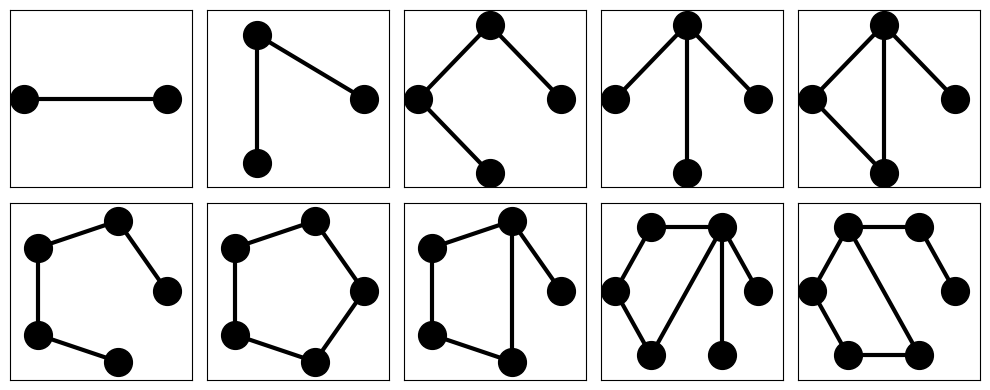

In [74]:
spatial_patterns = executions['spatial_pattern'].unique()
from qqespm_quadtree_CGA import SpatialPatternGraph
spatial_patterns = [SpatialPatternGraph.from_json(sp) for sp in spatial_patterns]
print('Total spatial patterns:', len(spatial_patterns))

fig, ax = plt.subplots(2,5)
fig.set_figwidth(10)
fig.set_figheight(4)
index_to_ax = {
    0: (0,0),
    12: (0,1),
    24: (0,2),
    30: (0,3),
    36: (0,4),
    42: (1,0),
    48: (1,1),
    54: (1,2),
    60: (1,3),
    66: (1,4)
}
for i in range(0, 72, 6):
    if i==6 or i==18:
        continue
    spatial_patterns[i].plot_structure(figwidth=4, figheight=3, xlim = (-1.2, 1.35), ylim = (-1.2, 1.2), node_size=400, edge_width=3.0, ax = ax[index_to_ax[i]])
plt.show()

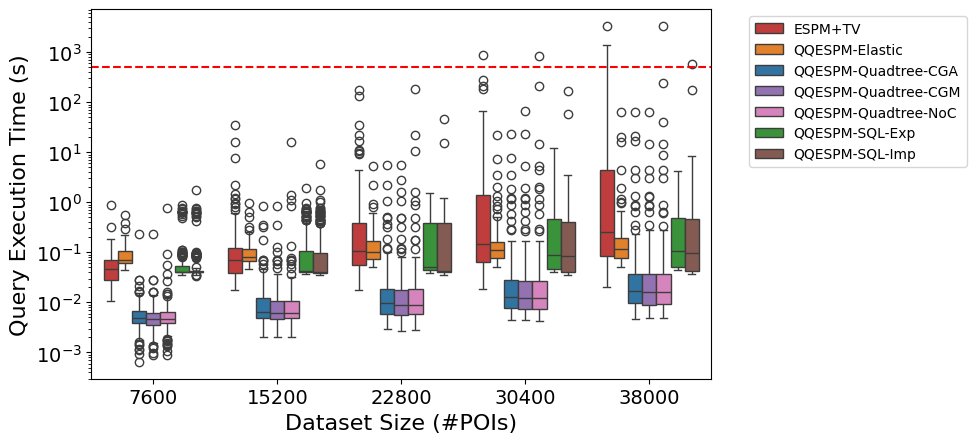

In [7]:
module_to_colors = {"QQESPM-Quadtree-CGA": "tab:blue", 
                    "QQESPM-Quadtree-CGM": "tab:purple", 
                    "QQESPM-Quadtree-NoC": "tab:pink",
                    "ESPM+TV": "tab:red",
                    "QQESPM-Elastic": "tab:orange",
                    "QQESPM-SQL-Imp": "tab:brown",
                    "QQESPM-SQL-Exp": "tab:green",
                    }

palette = [module_to_colors[libr] for libr in executions['module'].values]

fig, ax = plt.subplots()
fig.set_figwidth(8)

ax.set_yscale('log', base=10)
#ax.set_ylim(3*10**(-4), 10**4)
#estimator=(lambda e: np.percentile(e, [90])[0]), 
sns.boxplot(data=executions, x="dataset_size", y="elapsed_time", hue="module", palette=palette)#, errorbar=None, lw=4)#estimator='mean', 
ax.set_xticklabels(executions['dataset_size'].value_counts().index.tolist(), fontsize=14, rotation=0)
ax.set_yticklabels(ax.get_yticks(), fontsize=14)
ax.yaxis.set_major_formatter(matplotlib.ticker.LogFormatterMathtext())
ax.set_xlabel('Dataset Size (#POIs)', fontsize=16, )
ax.set_ylabel('Query Execution Time (s)', fontsize=16, )
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.axhline(y = 500, color = 'r', linestyle = 'dashed')   

#### Experiment 2

In [75]:
executions = pd.read_csv('executions_comparison_london_experiment2.csv', names = ['repetition', 'sp_index', 'spatial_pattern', 'number_of_vertices', 
        'number_of_edges', 'number_of_exclusions', 'qualitative_prob', 'dataset_size', 'module', 'total_solutions', 'elapsed_time', 'memory_usage'], index_col=False)
print('Total executions:', executions.shape[0])
executions.head()

Total executions: 6480


,repetition,sp_index,spatial_pattern,number_of_vertices,number_of_edges,number_of_exclusions,qualitative_prob,dataset_size,module,total_solutions,elapsed_time,memory_usage
0,1,0,"{""vertices"": [{""id"": 0, ""keyword"": ""furniture""...",2,1,0,1.0,25595,qq_quadtree,0,0.024591,292.843750
1,1,0,"{""vertices"": [{""id"": 0, ""keyword"": ""furniture""...",2,1,0,1.0,25595,qq_elastic,0,0.360442,32919.667969
2,1,0,"{""vertices"": [{""id"": 0, ""keyword"": ""furniture""...",2,1,0,1.0,25595,qq_sql,0,0.047104,16017.355469
3,1,0,"{""vertices"": [{""id"": 0, ""keyword"": ""furniture""...",2,1,0,1.0,51190,qq_quadtree,0,0.070517,297.195312
4,1,0,"{""vertices"": [{""id"": 0, ""keyword"": ""furniture""...",2,1,0,1.0,51190,qq_elastic,0,0.147634,32961.960938


In [76]:
executions.loc[executions['module']=='qq_quadtree', 'module'] = 'QQESPM-Quadtree'
executions.loc[executions['module']=='qq_elastic', 'module'] = 'QQESPM-Elastic'
executions.loc[executions['module']=='qq_sql', 'module'] = 'QQESPM-SQL'

In [77]:
executions_summarized = executions.groupby(['sp_index', 'dataset_size', 'module', 'spatial_pattern', 'number_of_vertices', 
        'number_of_edges', 'number_of_exclusions', 'qualitative_prob', 'total_solutions'], as_index=False)[['elapsed_time', 'memory_usage']].mean()
executions = executions_summarized
executions.shape

(2160, 11)

In [83]:
executions['dataset_size'].value_counts()

dataset_size
25595     432
51190     432
76785     432
102380    432
127975    432
Name: count, dtype: int64

Total spatial patterns: 144


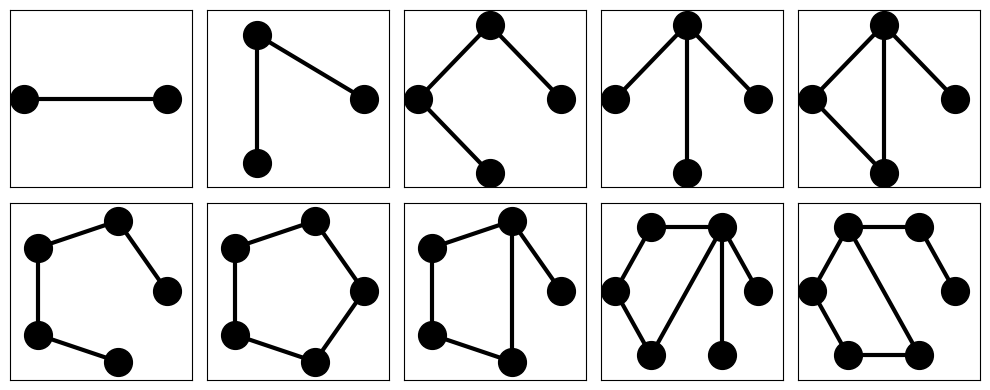

In [84]:
spatial_patterns = executions['spatial_pattern'].unique()
from qqespm_quadtree_CGA import SpatialPatternGraph
spatial_patterns = [SpatialPatternGraph.from_json(sp) for sp in spatial_patterns]
print('Total spatial patterns:', len(spatial_patterns))

fig, ax = plt.subplots(2,5)
fig.set_figwidth(10)
fig.set_figheight(4)
index_to_ax = {
    0: (0,0),
    12: (0,1),
    24: (0,2),
    30: (0,3),
    36: (0,4),
    42: (1,0),
    48: (1,1),
    54: (1,2),
    60: (1,3),
    66: (1,4)
}
for i in range(0, 72, 6):
    if i==6 or i==18:
        continue
    spatial_patterns[i].plot_structure(figwidth=4, figheight=3, xlim = (-1.2, 1.35), ylim = (-1.2, 1.2), node_size=400, edge_width=3.0, ax = ax[index_to_ax[i]])
plt.show()

In [85]:
executions['module'].value_counts()

module
QQESPM-Elastic     720
QQESPM-Quadtree    720
QQESPM-SQL         720
Name: count, dtype: int64

In [79]:
executions_100perc = executions[executions['dataset_size']==127975]

In [80]:
executions[(executions['module']=='QQESPM-SQL')]['elapsed_time'].describe()

count    720.000000
mean       1.023581
std        5.697749
min        0.041263
25%        0.066554
50%        0.305581
75%        0.610111
max       97.308267
Name: elapsed_time, dtype: float64

In [81]:
executions[executions['module']=='QQESPM-Elastic']['elapsed_time'].describe()

count     720.000000
mean        5.742464
std        65.890117
min         0.051769
25%         0.086993
50%         0.140842
75%         0.281519
max      1423.378564
Name: elapsed_time, dtype: float64

In [82]:
executions[executions['module']=='QQESPM-Quadtree']['elapsed_time'].describe()

count     720.000000
mean        4.501083
std        61.907987
min         0.001721
25%         0.007934
50%         0.016215
75%         0.052979
max      1486.109050
Name: elapsed_time, dtype: float64

In [16]:
qq_quadtree_stats = executions[executions['module']=='QQESPM-Quadtree']['elapsed_time'].describe().to_frame(name='Elapsed Time').reset_index()
qq_quadtree_stats.rename(columns={'index': 'Estimator'}, inplace=True)
qq_quadtree_stats['module'] = 'QQESPM-Quadtree'
qq_quadtree_stats

qq_elastic_stats = executions[executions['module']=='QQESPM-Elastic']['elapsed_time'].describe().to_frame(name='Elapsed Time').reset_index()
qq_elastic_stats.rename(columns={'index': 'Estimator'}, inplace=True)
qq_elastic_stats['module'] = 'QQESPM-Elastic'
qq_elastic_stats

qq_sql_stats = executions[executions['module']=='QQESPM-SQL']['elapsed_time'].describe().to_frame(name='Elapsed Time').reset_index()
qq_sql_stats.rename(columns={'index': 'Estimator'}, inplace=True)
qq_sql_stats['module'] = 'QQESPM-SQL'
qq_sql_stats

stats = pd.concat([qq_quadtree_stats, qq_elastic_stats, qq_sql_stats])
#stats = stats[stats['Estimator']!='count']
small_stats = stats[(stats['Estimator']!='count')&(stats['Estimator']!='max')&(stats['Estimator']!='std')&(stats['Estimator']!='mean')]
big_stats = stats[(stats['Estimator']=='mean')|(stats['Estimator']=='max')|(stats['Estimator']=='std')]
print(small_stats.shape)
print(big_stats.shape)
small_stats.head()

(12, 3)
(9, 3)


,Estimator,Elapsed Time,module
3,min,0.001721,QQESPM-Quadtree
4,25%,0.007934,QQESPM-Quadtree
5,50%,0.016215,QQESPM-Quadtree
6,75%,0.052979,QQESPM-Quadtree
3,min,0.051769,QQESPM-Elastic


In [17]:
general_stats = pd.crosstab(stats.module, stats.Estimator, values=stats['Elapsed Time'], aggfunc='mean').round(3)
general_stats = general_stats[['count','min','25%','50%','75%','mean','std','max']]
general_stats.rename(columns={'count': 'total queries'}, inplace=True)
general_stats.columns.name = 'Statistic'
general_stats.index.name = 'Library'
general_stats

Statistic,total queries,min,25%,50%,75%,mean,std,max
Library,,,,,,,,
QQESPM-Elastic,720.0,0.052,0.087,0.141,0.282,5.742,65.890,1423.379
QQESPM-Quadtree,720.0,0.002,0.008,0.016,0.053,4.501,61.908,1486.109
QQESPM-SQL,720.0,0.041,0.067,0.306,0.610,1.024,5.698,97.308


In [18]:
executions['dataset_size_str'] = executions['dataset_size'].astype(str)
executions_qqespm_quadtree = executions[executions['module']=='QQESPM-Quadtree']
executions_qqespm_elastic = executions[executions['module']=='QQESPM-Elastic']
executions_qqespm_sql = executions[executions['module']=='QQESPM-SQL']
executions_qqespm_sql.shape

(720, 12)

Text(0, 0.5, 'Median Execution Time (s)')

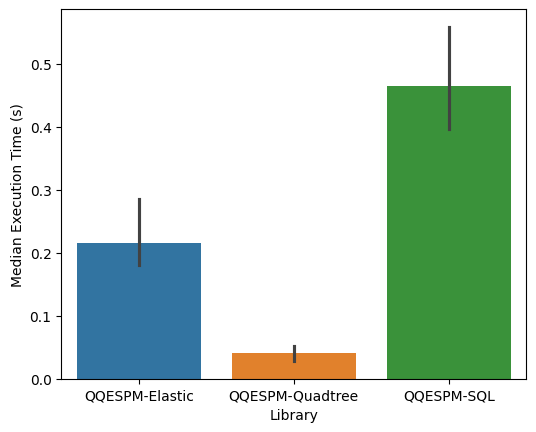

In [19]:
fig, ax = plt.subplots()
fig.set_figwidth(6)
#ax.set_yscale('log', base=10)
#ax.set_ylim(3*10**(-4), 10**3)


sns.barplot(data = executions_100perc, y="elapsed_time", x = 'module', hue = 'module', estimator='median', ax = ax)
ax.set_xlabel('Library')
ax.set_ylabel('Median Execution Time (s)')

#plt.grid(axis='y')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Overall average query times

In [20]:
executions_20perc = executions[executions['dataset_size_str']=='25595']
executions_40perc = executions[executions['dataset_size_str']=='51190']
executions_60perc = executions[executions['dataset_size_str']=='76785']
executions_80perc = executions[executions['dataset_size_str']=='102380']
executions_100perc = executions[executions['dataset_size_str']=='127975']

print(executions_20perc.shape)
print(executions_40perc.shape)
print(executions_60perc.shape)
print(executions_80perc.shape)
print(executions_100perc.shape)


(432, 12)
(432, 12)
(432, 12)
(432, 12)
(432, 12)


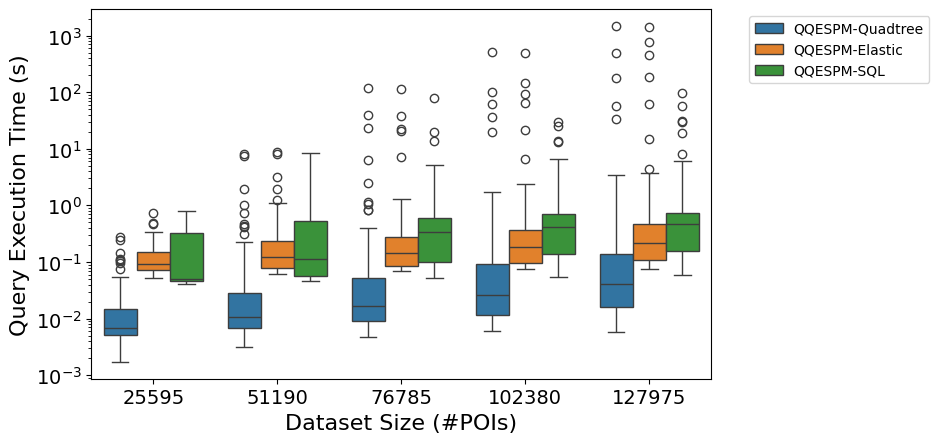

In [21]:
fig, ax = plt.subplots()
fig.set_figwidth(8)

ax.set_yscale('log', base=10)
#ax.set_ylim(3*10**(-4), 10**4)
#estimator=(lambda e: np.percentile(e, [90])[0]), 
sns.boxplot(data=executions, x="dataset_size", y="elapsed_time", hue="module", hue_order=['QQESPM-Quadtree', 'QQESPM-Elastic', 'QQESPM-SQL'])#, palette=palette)#, errorbar=None, lw=4)#estimator='mean', 
ax.set_xticklabels(executions['dataset_size'].value_counts().index.tolist(), fontsize=14, rotation=0)
ax.set_yticklabels(ax.get_yticks(), fontsize=14)
ax.yaxis.set_major_formatter(matplotlib.ticker.LogFormatterMathtext())
ax.set_xlabel('Dataset Size (#POIs)', fontsize=16, )
ax.set_ylabel('Query Execution Time (s)', fontsize=16, )
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

#plt.axhline(y = 500, color = 'r', linestyle = 'dashed')   

In [22]:
module_to_colors = {"QQESPM-Quadtree": "tab:blue", 
                    "QQESPM-Elastic": "tab:orange",
                    "QQESPM-SQL": "tab:green",
                    }
palette = [module_to_colors[libr] for libr in executions['module'].values]

In [23]:
print('95th percentile qqespm_elastic:', np.percentile(executions[executions['module']=='QQESPM-Elastic']['elapsed_time'], [95]))
print('95th percentile qqespm_sql:', np.percentile(executions[executions['module']=='QQESPM-SQL']['elapsed_time'], [95]))
print('95th percentile qqespm_quadtree:', np.percentile(executions[executions['module']=='QQESPM-Quadtree']['elapsed_time'], [95]))

95th percentile qqespm_elastic: [1.14595554]
95th percentile qqespm_sql: [1.22738289]
95th percentile qqespm_quadtree: [0.74992572]


In [24]:
# plt.rcParams['font.size'] = 16
# plt.rcParams['lines.markersize'] = 18 
# plt.rcParams['xtick.labelsize'] = 16
# plt.rcParams['ytick.labelsize'] = 16
# plt.rcParams['axes.titlesize'] = 20
# plt.rcParams['legend.fontsize'] = 16

In [25]:
executions_quadtree = executions[executions['module']=='QQESPM-Quadtree']
executions_elastic = executions[executions['module']=='QQESPM-Elastic']
executions_sql = executions[executions['module']=='QQESPM-SQL']

In [26]:
def extract_keywords(spatial_pattern_dict):
    keywords = []
    for v in spatial_pattern_dict['vertices']:
        keywords.append(v['keyword'])
    return keywords

executions['keywords'] = executions['spatial_pattern'].apply(json.loads).apply(extract_keywords)

In [ ]:
pois = pd.read_csv('data/london_pois_bbox.csv')
pois.shape

(127975, 10)

In [28]:
frequent_keywords = list(set().union(
    set(pois['amenity'].value_counts().head(25).to_dict().items()),
    set(pois['shop'].value_counts().head(25).to_dict().items()),
    set(pois['tourism'].value_counts().head(25).to_dict().items()),
    set(pois['landuse'].value_counts().head(25).to_dict().items()),
    set(pois['leisure'].value_counts().head(25).to_dict().items()),
    set(pois['building'].value_counts().head(25).to_dict().items()),
))

In [29]:
frequent_keywords_df = pd.DataFrame(sorted(frequent_keywords, key=lambda e:e[1], reverse=True), columns=['Keyword', 'Frequency'])
frequent_keywords_df.head()

,Keyword,Frequency
0,residential,21775
1,bicycle_parking,10811
2,apartments,10606
3,terrace,7781
4,bench,4726


In [30]:
frequent_keywords_df2 = frequent_keywords_df.groupby(['Keyword'], as_index=False)['Frequency'].sum()

In [31]:
frequent_keywords_df2 = frequent_keywords_df2.sort_values(by='Frequency', ascending=False).head(25)

In [32]:
frequent_keywords_df.shape, frequent_keywords_df2.shape

((148, 2), (25, 2))

In [33]:
frequent_keywords_df2[frequent_keywords_df2.Keyword=='residential']

,Keyword,Frequency
106,residential,26014


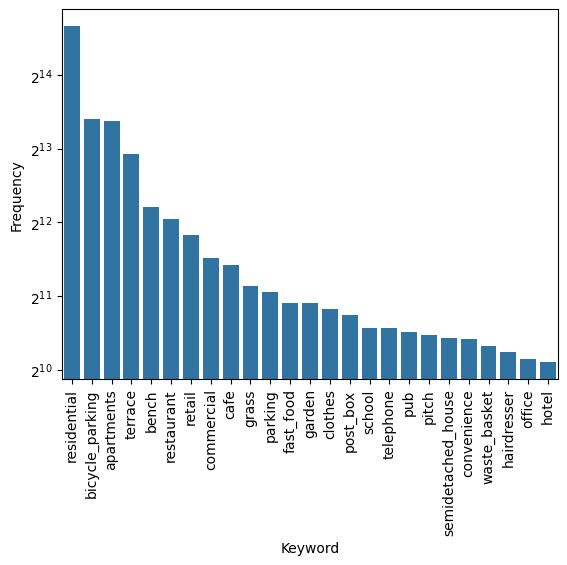

In [34]:
fig, ax = plt.subplots()
ax.set_yscale('log', base=2)
sns.barplot(frequent_keywords_df2, x = 'Keyword', y = 'Frequency', ax=ax, order=frequent_keywords_df2.sort_values(
    by='Frequency', ascending=False).Keyword)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=90)
#ax.set_xlabel('Library')
#ax.set_ylabel('Variation of Memory Allocation (MB) ')
#|ax.set_title('Top-25 Most Frequent Keywords in the Dataset')
plt.show()

In [35]:
executions[(executions['module']=='QQESPM-Quadtree')&(
                    executions['total_solutions']>100000)]['elapsed_time'].describe()

count      17.000000
mean      185.886212
std       369.343411
min         0.760033
25%        19.834519
50%        40.381133
75%       116.919740
max      1486.109050
Name: elapsed_time, dtype: float64

In [36]:
executions_quadtree = executions[executions['module']=='QQESPM-Quadtree']
executions_elastic = executions[executions['module']=='QQESPM-Elastic']
executions_sql = executions[executions['module']=='QQESPM-SQL']

In [37]:
from matplotlib import colormaps
list(colormaps)[:5]

['magma', 'inferno', 'plasma', 'viridis', 'cividis']

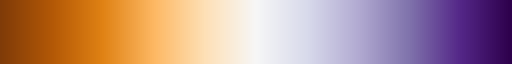

In [38]:
matplotlib.colormaps['PuOr']

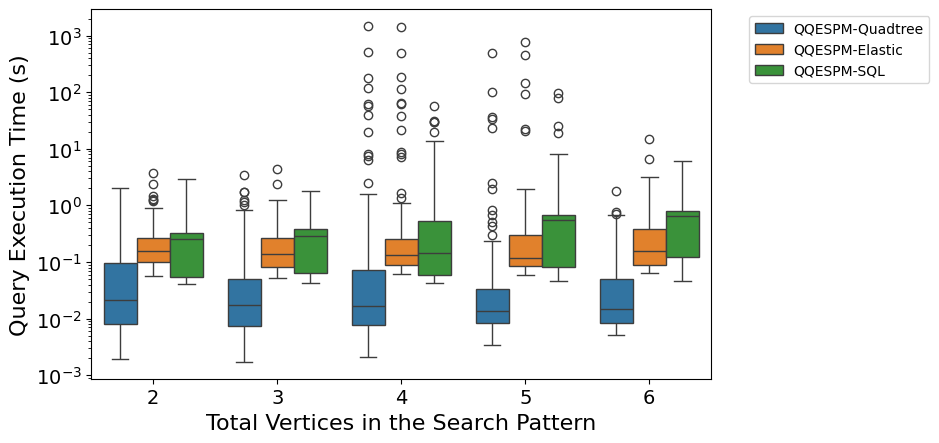

In [39]:
fig, ax = plt.subplots()
fig.set_figwidth(8)

ax.set_yscale('log', base=10)
#ax.set_ylim(3*10**(-4), 10**4)
#estimator=(lambda e: np.percentile(e, [90])[0]), 
sns.boxplot(data=executions, x="number_of_vertices", y="elapsed_time", hue="module", hue_order=['QQESPM-Quadtree', 'QQESPM-Elastic', 'QQESPM-SQL'])#, palette=palette)#, errorbar=None, lw=4)#estimator='mean', 
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=0)
ax.set_yticklabels(ax.get_yticks(), fontsize=14)
ax.yaxis.set_major_formatter(matplotlib.ticker.LogFormatterMathtext())
ax.set_xlabel('Total Vertices in the Search Pattern', fontsize=16, )
ax.set_ylabel('Query Execution Time (s)', fontsize=16, )
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

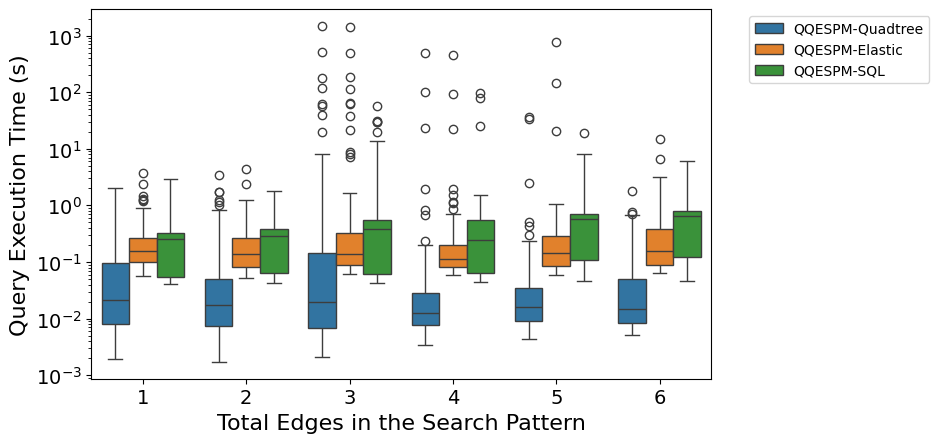

In [40]:
fig, ax = plt.subplots()
fig.set_figwidth(8)

ax.set_yscale('log', base=10)
#ax.set_ylim(3*10**(-4), 10**4)
#estimator=(lambda e: np.percentile(e, [90])[0]), 
sns.boxplot(data=executions, x="number_of_edges", y="elapsed_time", hue="module", hue_order=['QQESPM-Quadtree', 'QQESPM-Elastic', 'QQESPM-SQL'])#, palette=palette)#, errorbar=None, lw=4)#estimator='mean', 
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=0)
ax.set_yticklabels(ax.get_yticks(), fontsize=14)
ax.yaxis.set_major_formatter(matplotlib.ticker.LogFormatterMathtext())
ax.set_xlabel('Total Edges in the Search Pattern', fontsize=16, )
ax.set_ylabel('Query Execution Time (s)', fontsize=16, )
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

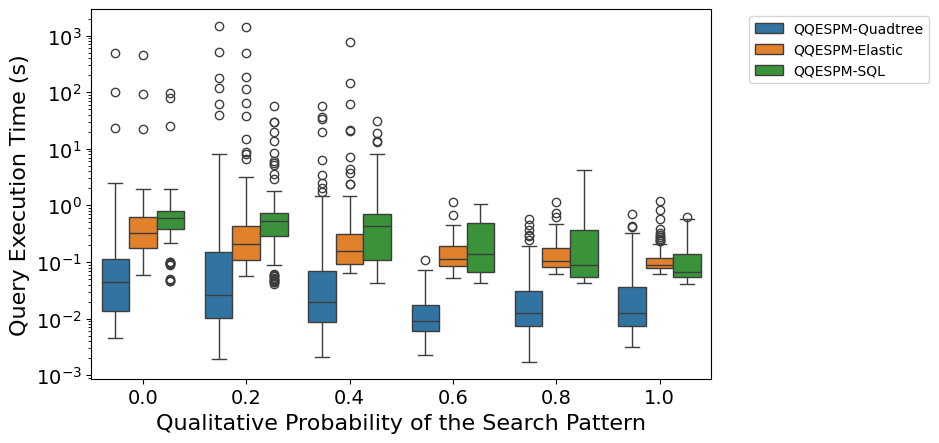

In [41]:
fig, ax = plt.subplots()
fig.set_figwidth(8)

ax.set_yscale('log', base=10)
#ax.set_ylim(3*10**(-4), 10**4)
#estimator=(lambda e: np.percentile(e, [90])[0]), 
sns.boxplot(data=executions, x="qualitative_prob", y="elapsed_time", hue="module", hue_order=['QQESPM-Quadtree', 'QQESPM-Elastic', 'QQESPM-SQL'])#, palette=palette)#, errorbar=None, lw=4)#estimator='mean', 
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=0)
ax.set_yticklabels(ax.get_yticks(), fontsize=14)
ax.yaxis.set_major_formatter(matplotlib.ticker.LogFormatterMathtext())
ax.set_xlabel('Qualitative Probability of the Search Pattern', fontsize=16, )
ax.set_ylabel('Query Execution Time (s)', fontsize=16, )
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

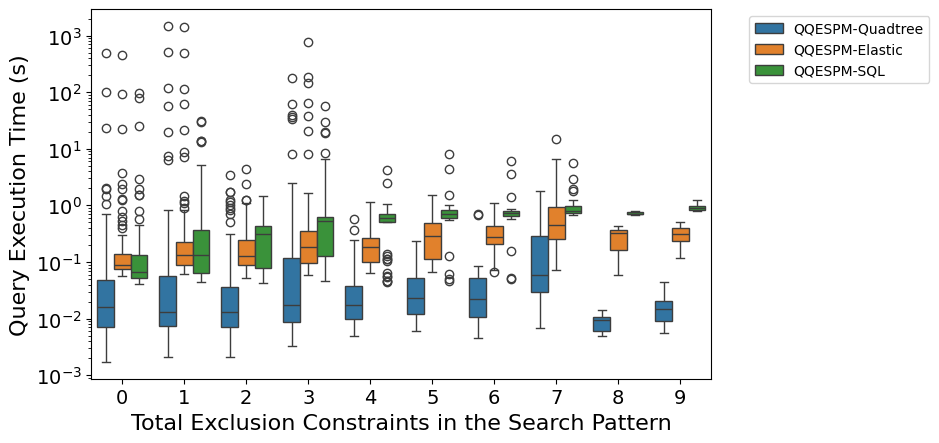

In [42]:
fig, ax = plt.subplots()
fig.set_figwidth(8)

ax.set_yscale('log', base=10)
#ax.set_ylim(3*10**(-4), 10**4)
#estimator=(lambda e: np.percentile(e, [90])[0]), 
sns.boxplot(data=executions, x="number_of_exclusions", y="elapsed_time", hue="module", hue_order=['QQESPM-Quadtree', 'QQESPM-Elastic', 'QQESPM-SQL'])#, palette=palette)#, errorbar=None, lw=4)#estimator='mean', 
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=0)
ax.set_yticklabels(ax.get_yticks(), fontsize=14)
ax.yaxis.set_major_formatter(matplotlib.ticker.LogFormatterMathtext())
ax.set_xlabel('Total Exclusion Constraints in the Search Pattern', fontsize=16, )
ax.set_ylabel('Query Execution Time (s)', fontsize=16, )
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Memory Usage Assessment

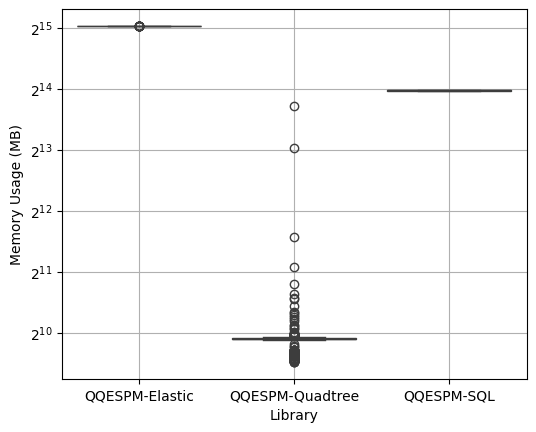

In [43]:
fig, ax = plt.subplots()
fig.set_figwidth(6)
ax.set_yscale('log', base=2)
#ax.set_ylim(3*10**(-4), 10**3)


sns.boxplot(data = executions, y="memory_usage", x = 'module', hue = 'module', ax = ax, showmeans=False, meanprops={'marker':'^',
                       'markerfacecolor':'white', 
                       'markeredgecolor':'black',
                       'markersize':'8'})
ax.set_xlabel('Library')
ax.set_ylabel('Memory Usage (MB)')

plt.grid()
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')